In [44]:
%pip install -qU \
    langchain==0.2.5 \
    langchain-core==0.2.9 \
    langgraph==0.1.1 \
    langchain_openai==0.1.9

Note: you may need to restart the kernel to use updated packages.


In [1]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [11]:
from langchain_core.tools import tool


@tool("website_schema_validator_tool")
def website_schema_validator_tool(website_schema: str = None) -> bool:
    """
    Validate a website schema

    Args:
    schema (str): The website schema to validate

    Returns:
    bool: Whether the schema is valid
    """
    return True if website_schema else False

In [13]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

In [14]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [16]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond([HumanMessage(content=example_question)])

In [23]:
initial.additional_kwargs["tool_calls"][0]["function"]["arguments"]

'{"answer":"Reflection is a crucial aspect of artificial intelligence (AI) for several reasons. Firstly, it enhances decision-making processes. AI systems that incorporate reflection can analyze their past actions and outcomes to make better-informed decisions in the future. This capability is particularly important in dynamic environments where conditions can change rapidly, requiring adaptive learning and response. Secondly, reflection in AI contributes to improved learning and adaptation. By reflecting on errors or suboptimal decisions, AI systems can identify patterns and adjust their learning algorithms to avoid repeating mistakes. This iterative learning process can lead to more accurate and reliable performance over time. Thirdly, reflection supports transparency and interpretability in AI. When AI systems can reflect on their decision-making processes, it becomes easier for developers and users to understand how conclusions are reached. This transparency is vital in building tr

In [8]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [9]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                website_schema_validator_tool.invoke(
                    {"query": initial.tool_calls[0]["args"]["reflection"]["search_queries"][0]}
                )
            ),
        ),
    ]
)
revised

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dqREZi4xX0af1TOOsXb82NUz', 'function': {'arguments': '{"answer":"Reflection in AI is crucial for several reasons. It enables continuous improvement as AI systems learn from past decisions and actions, identifying what went right or wrong to adapt their models accordingly. This process refines algorithms, improves accuracy, and enhances performance. Additionally, reflection aids in transparency and accountability. By documenting decision-making processes and outcomes, AI systems can explain their actions, building trust with users and complying with ethical standards. Reflection also fosters adaptability in dynamic environments, allowing AI systems to adjust strategies based on new data and evolving contexts. Lastly, reflection supports ethical AI development by considering long-term impacts and unintended consequences, promoting designs that align with societal values and norms.","reflection":{"missing":"The answer co

In [10]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return website_schema_validator_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [11]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

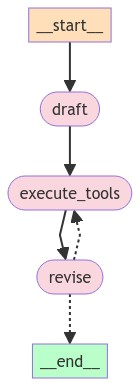

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [2]:
graph.invoke(
    {
        "messages": "How should we handle the climate crisis?",
    }
)

NameError: name 'graph' is not defined